In [1]:
import sys
import os
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/src/"))
from motif.moods import import_moods_hits
from motif.tfmodisco_hit_scoring import import_tfmodisco_hits
import pyBigWig
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import tqdm
tqdm.tqdm_notebook()  # It is necessary to call this before the tqdm.notebook submodule is available

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if sys.path[0] == '':


0it [00:00, ?it/s]

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  after removing the cwd from sys.path.


### Define constants and paths

In [3]:
head = "count"

tf_names = ["Nanog", "Oct4", "Sox2"]
chipnexus_peak_paths = [
    "/users/amtseng/tfmodisco/data/raw/BPNet/BPNet_%s_ChIPnexus_idr-peaks.bed.gz" % tf_name
    for tf_name in tf_names
]

chipnexus_bigwig_paths = [
    tuple([
        os.path.join(
            "/users/amtseng/tfmodisco/data/raw/BPNet",
            "BPNet_%s_ChIPnexus_%s.bw" % (tf_name, strand)
        )
        for strand in ("neg", "pos")
    ])
    for tf_name in tf_names
]

# hits_cache_path = "/users/amtseng/tfmodisco/results/reports/motif_hits/cache/"
# moods_hit_paths = [
#     os.path.join(
#         hits_cache_path,
#         "moods/BPNet",
#         "BPNet_%s_ChIPseq" % tf_name,
#         "BPNet_%s_ChIPseq_%s" % (tf_name, head),
#         "filtered_hits.tsv"
#     ) for tf_name in tf_names
# ]
# tfm_hit_paths = [
#     os.path.join(
#         hits_cache_path,
#         "tfm/BPNet",
#         "BPNet_%s_ChIPseq" % tf_name,
#         "BPNet_%s_ChIPseq_%s" % (tf_name, head),
#         "filtered_hits.tsv"
#     ) for tf_name in tf_names
# ]

resuts_path = "/users/amtseng/tfmodisco/results/"
moods_hit_paths = [
    os.path.join(
        resuts_path,
        "moods/BPNet",
        "BPNet_%s_ChIPseq" % tf_name,
        "BPNet_%s_ChIPseq_%s" % (tf_name, head),
        "moods_filtered_collapsed_scored_collapsed.bed"
    ) for tf_name in tf_names
]
tfm_hit_paths = [
    os.path.join(
        resuts_path,
        "tfmodisco_hit_scoring/BPNet",
        "BPNet_%s_ChIPseq" % tf_name,
        "BPNet_%s_ChIPseq_%s" % (tf_name, head),
        "tfm_matches_collapsed.bed"
    ) for tf_name in tf_names
]

### Import motif hits and ChIP-nexus peaks

In [4]:
def import_motif_hits(motif_hits_path):
    """
    Imports the motif hits, which may be an output of MOODS scanning
    or TF-MoDISco hit scanning, and may be filtered hits. Depending on
    the number of columns, the hits are imported appropriately.
    """
    with open(motif_hits_path, "r") as f:
        cols = next(f).split("\t")
    if motif_hits_path.endswith(".tsv"):
        hit_table = pd.read_csv(motif_hits_path, sep="\t", header=0, index_col=None)
        hit_table = hit_table.drop("index", axis=1)
    elif len(cols) == 8:
        # MOODS hits
        hit_table = import_moods_hits(motif_hits_path)
    elif len(cols) == 14:
        # TF-MoDISco hits
        hit_table = import_tfmodisco_hits(motif_hits_path)
        
        # Sort by aggregate similarity and drop duplicates (by strand)
        hit_table = hit_table.sort_values("agg_sim")
        hit_table = hit_table.drop_duplicates(["chrom", "start", "end", "peak_index"], keep="last")
    else:
        raise ValueError("Motif hits file of unknown format/source: %s" % motif_hits_path)
    return hit_table

In [5]:
def import_chipnexus_peaks(peak_bed_path):
    """
    Imports the ChIP-nexus peaks in ENCODE NarrowPeak format, and
    adds the `summit` column.
    """
    peak_table = pd.read_csv(
        peak_bed_path, sep="\t", header=None,
        names=[
            "chrom", "peak_start", "peak_end", "name", "score", "strand",
            "signal", "pval", "qval", "summit_offset"
        ]
    )
    peak_table["summit"] = peak_table["peak_start"] + peak_table["summit_offset"]
    return peak_table

In [6]:
moods_hits = [
    import_motif_hits(path) for path in moods_hit_paths
]
tfm_hits = [
    import_motif_hits(path) for path in tfm_hit_paths
]

In [7]:
chipnexus_peaks = [
    import_chipnexus_peaks(path) for path in chipnexus_peak_paths
]

### Fetch the ChIP-nexus peak summits
Only the summits with profile height above the 90th percentile

In [8]:
for peak_table, (neg_bw_path, pos_bw_path) in zip(chipnexus_peaks, chipnexus_bigwig_paths):
    with pyBigWig.open(neg_bw_path, "r") as neg_bw, pyBigWig.open(pos_bw_path, "r") as pos_bw:
        profile_heights = np.empty(len(peak_table))
        for i, row in tqdm.notebook.tqdm(peak_table.iterrows(), total=len(peak_table)):
            neg_val = np.nan_to_num(neg_bw.values(row["chrom"], row["summit"], row["summit"] + 1))
            pos_val = np.nan_to_num(pos_bw.values(row["chrom"], row["summit"], row["summit"] + 1))
            profile_heights[i] = neg_val + pos_val
    peak_table["profile_height"] = profile_heights

In [9]:
perc_cutoffs = [
    np.percentile(peak_table["profile_height"], 90)
    for peak_table in chipnexus_peaks
]

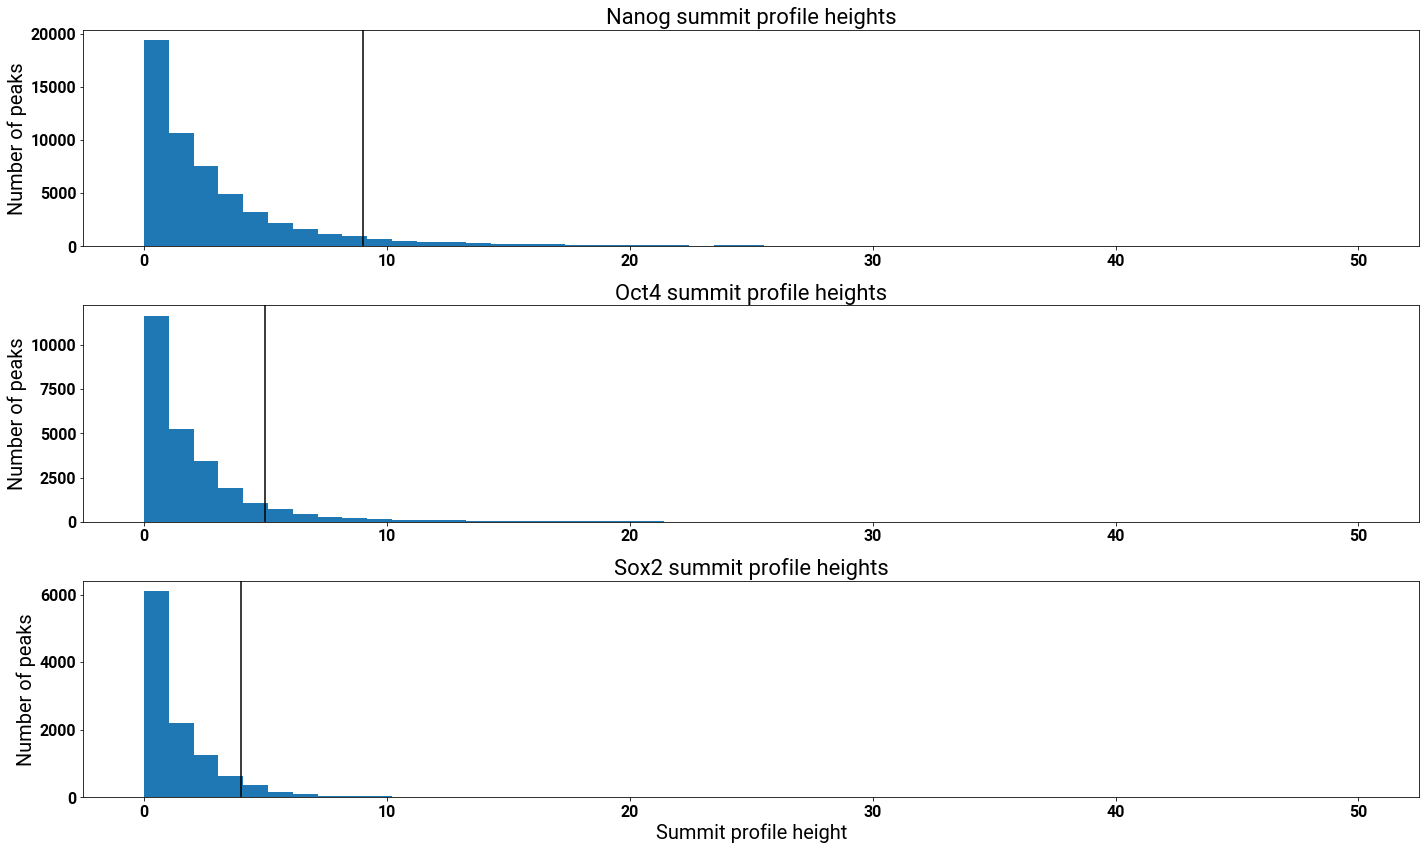

In [10]:
fig, ax = plt.subplots(nrows=len(tf_names), figsize=(20, len(tf_names) * 4))
for i in range(len(tf_names)):
    ax[i].hist(chipnexus_peaks[i]["profile_height"], bins=np.linspace(0, 50, 50))
    ax[i].set_ylabel("Number of peaks")
    ax[i].set_title("%s summit profile heights" % tf_names[i])
    
    ax[i].axvline(perc_cutoffs[i], color="black")

ax[-1].set_xlabel("Summit profile height")
fig.tight_layout()

In [11]:
# Cut off low-profile-height peaks
for i, peak_table in enumerate(chipnexus_peaks):
    chipnexus_peaks[i] = peak_table[peak_table["profile_height"] >= perc_cutoffs[i]]

### Compute distances to peak summits
For each motif hit, compute the distance to the closest peak summit

In [12]:
def compute_summit_dists(query_coords, summit_coords):
    """
    From an N x 3 object array of query coordinates and an M x 2 array
    of summit coordinates, computes the distance of each query coordinate
    to the closest summit coordinate using coordinate midpoints.
    Returns an N-array of signed distances, with NaN being where nothing
    was found.
    """
    query_chroms = query_coords[:, 0]
    summit_chroms = summit_coords[:, 0]
    
    summit_coords_by_chrom = {}
    for chrom in np.unique(query_chroms):
        summit_coords_by_chrom[chrom] = summit_coords[summit_chroms == chrom][:, 1]
        
    midpoints = (query_coords[:, 1] + query_coords[:, 2]) // 2
    all_dists = np.empty(len(query_coords))
    all_dists[:] = np.nan
    for i in tqdm.notebook.trange(len(query_coords)):
        dists = midpoints[i] - summit_coords_by_chrom[query_chroms[i]]
        if not dists.size:
            continue
        min_dist = dists[np.argmin(np.abs(dists))]
        all_dists[i] = min_dist
    return all_dists

In [13]:
for hit_table, peak_table in zip(moods_hits, chipnexus_peaks):
    hit_table["dist_to_summit"] = compute_summit_dists(
        hit_table[["chrom", "start", "end"]].values,
        peak_table[["chrom", "summit"]].values
    )
for hit_table, peak_table in zip(tfm_hits, chipnexus_peaks):
    hit_table["dist_to_summit"] = compute_summit_dists(
        hit_table[["chrom", "start", "end"]].values,
        peak_table[["chrom", "summit"]].values
    )

### Show support of motif hits by peak summits

In [14]:
def get_ranked_mask(hit_table, dist_thresh):
    """
    For a table of N motif hits, orders the hits by relative importance
    and returns a boolean mask of which hits are within `dist_thresh` of
    a peak summit.
    """
    hit_table = hit_table.sort_values("imp_frac_score", ascending=False)
    return np.abs(hit_table["dist_to_summit"].values) < dist_thresh

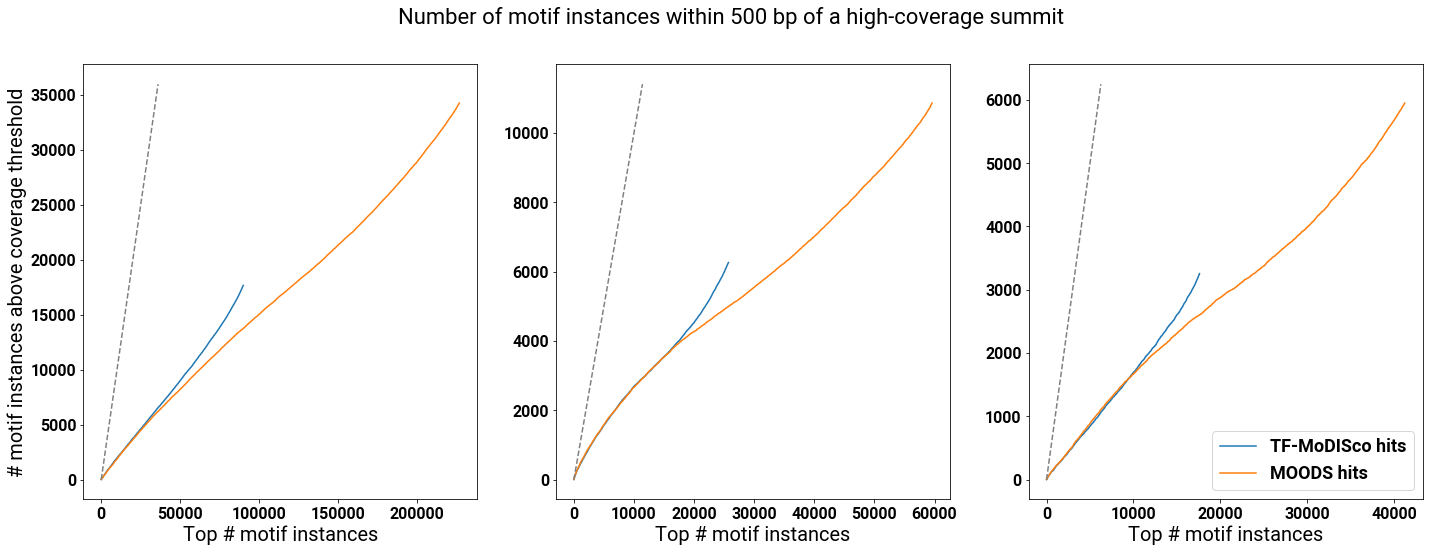

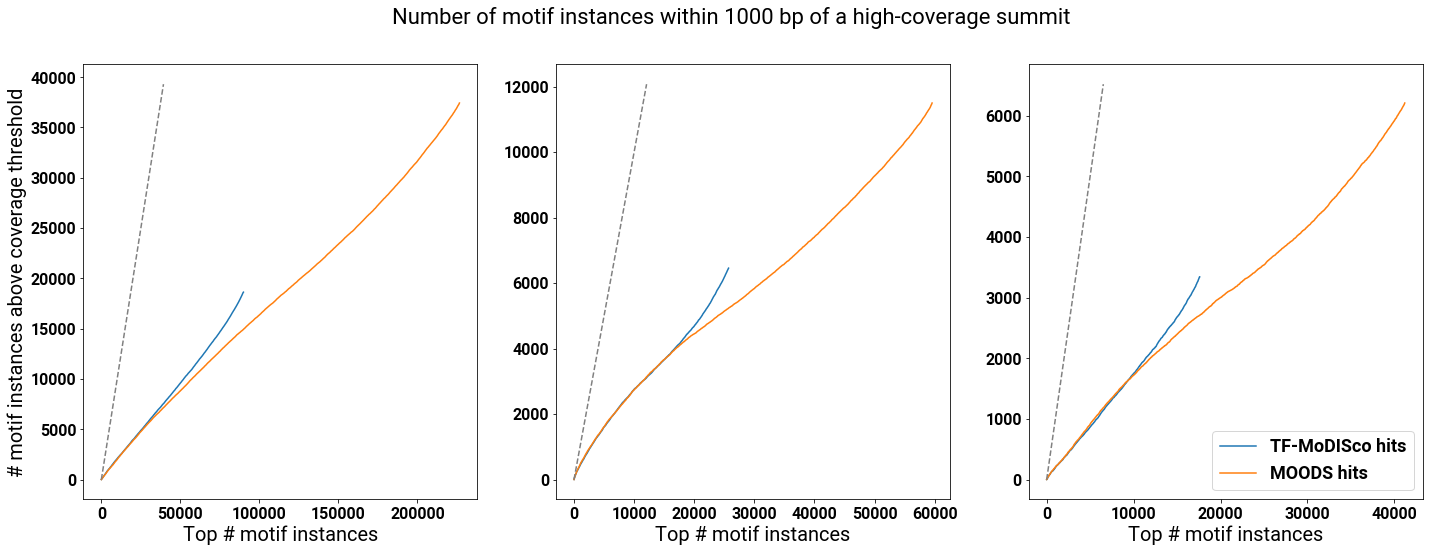

In [15]:
for dist_thresh in (500, 1000):
    fig, ax = plt.subplots(ncols=len(tf_names), figsize=(8 * len(tf_names), 8))
    for i in range(len(tf_names)):
        ax[i].plot(np.cumsum(get_ranked_mask(tfm_hits[i], dist_thresh)), label="TF-MoDISco hits")
        ax[i].plot(np.cumsum(get_ranked_mask(moods_hits[i], dist_thresh)), label="MOODS hits")
        ax[i].set_xlabel("Top # motif instances")
        xmax, ymax = ax[i].get_xlim()[1], ax[i].get_ylim()[1]
        ax[i].plot([0, min(xmax, ymax)], [0, min(xmax, ymax)], linestyle="--", color="gray")
    plt.legend()
    ax[0].set_ylabel("# motif instances above coverage threshold")
    fig.suptitle("Number of motif instances within %d bp of a high-coverage summit" % dist_thresh)